In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch
from torchmetrics import Precision, Recall
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load Dataset


In [5]:
# Compose transformations
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ]
)

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    root="../datasets/clouds_train",
    transform=train_transforms,
)

print(f"Number of classes in the dataset: {len(dataset_train.classes)}\n")
for i, class_name in enumerate(dataset_train.classes):
    print(f"Class {i}: {class_name}")

print(f"\nNumber of samples in the dataset: {len(dataset_train)}")

Number of classes in the dataset: 7

Class 0: cirriform clouds
Class 1: clear sky
Class 2: cumulonimbus clouds
Class 3: cumulus clouds
Class 4: high cumuliform clouds
Class 5: stratiform clouds
Class 6: stratocumulus clouds

Number of samples in the dataset: 474


## Display Image


Image shape before squeeze & permute:
 torch.Size([3, 64, 64])

Image shape after squeeze & permute:
 torch.Size([64, 64, 3])


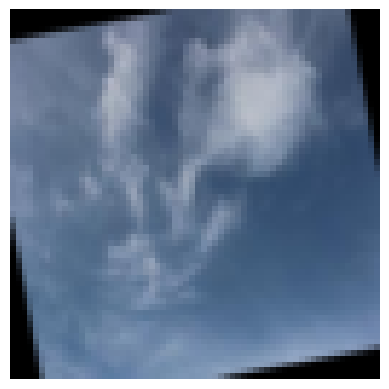

In [6]:
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=16)

image, label = dataloader_train.dataset[0]
print(f"Image shape before squeeze & permute:\n {image.shape}\n")

# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0)
print(f"Image shape after squeeze & permute:\n {image.shape}")

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()

## Building CNN


In [7]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )

        # Define classifier
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## Train Model


In [8]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.9487
Epoch 2, Loss: 1.5925
Epoch 3, Loss: 1.4633


## Evaluation

In [9]:
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ]
)

dataset_test = ImageFolder(
    root="../datasets/clouds_test",
    transform=test_transforms,
)

dataloader_test = DataLoader(dataset_test, shuffle=True, batch_size=16)

# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.5892949104309082
Recall: 0.6103159785270691
